# Plug in SimPEG's gravity simulation into the new framework

In [1]:
import discretize
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200])  # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(coordinates, prisms, densities, field="g_z")
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


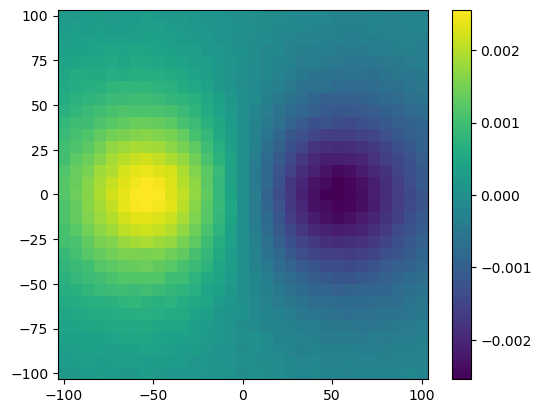

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
h = [(5.0, 40)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 64,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40       -100.00        100.00      5.00      5.00    1.00
   y     40       -100.00        100.00      5.00      5.00    1.00
   z     40       -200.00          0.00      5.00      5.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7f5723ab20d0>,)

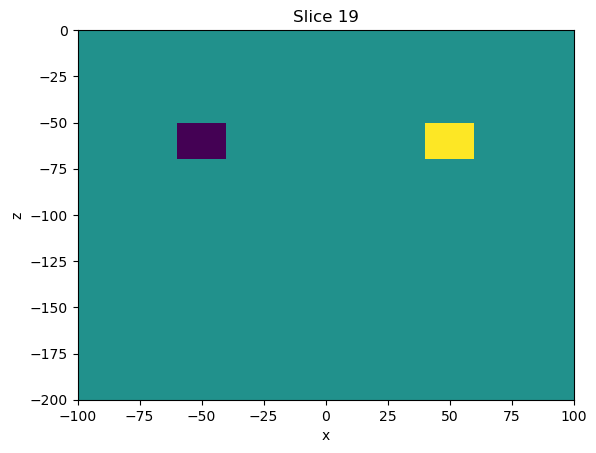

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

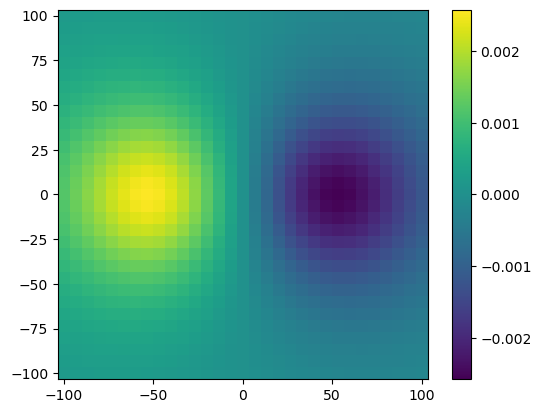

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Define (simple) inversion using the new framework

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = ii.wrap_simulation(simulation_simpeg)

In [15]:
dpred = simulation(model)

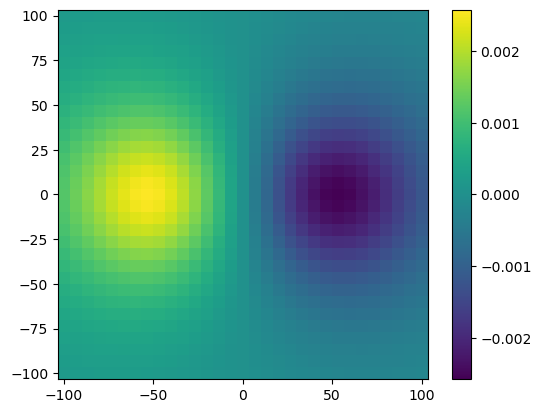

In [16]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [17]:
simulation.jacobian(model)

<961x64000 _CustomLinearOperator with dtype=float64>

In [18]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)

In [19]:
depth_weights = depth_weighting(mesh, 0) ** 2
smallness = ii.Smallness(mesh=mesh, cell_weights=depth_weights)

In [20]:
phi = data_misfit + 1e5 * smallness

In [21]:
initial_model = np.zeros(simulation.n_params)
inverted_model = ii.conjugate_gradient(phi, initial_model)

In [22]:
inverted_model

array([-2.39355341e-04, -2.41953362e-04, -2.43101081e-04, ...,
       -8.39879235e-05,  4.17242139e-05, -1.40597867e-04], shape=(64000,))

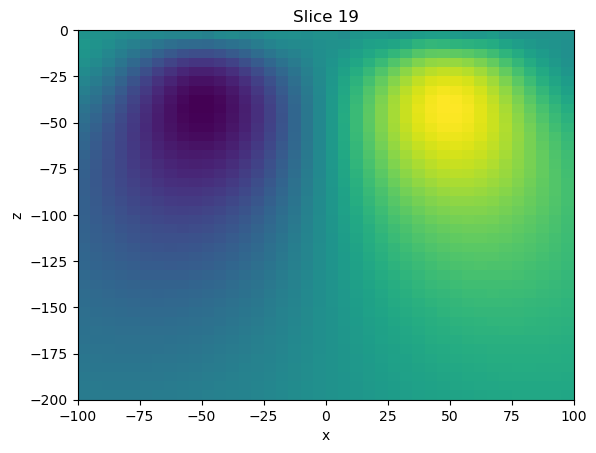

In [23]:
mesh.plot_slice(inverted_model, normal="Y", slice_loc=0)
plt.show()

In [24]:
data_misfit.chi_factor(inverted_model)

np.float64(0.49141366929150293)

## Run inversion with beta cooling

In [25]:
beta_0 = 1e7
regularization = beta_0 * smallness
phi = data_misfit + regularization
phi

φd(m) + 1.00e+07 φs(m)

In [26]:
# Initial model
initial_model = np.zeros(simulation.n_params)

# Stopping criteria
chi_target = 1.0
stopping_criteria = ii.ChiTarget(data_misfit, chi_target=chi_target)

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Inversion
inversion = ii.Inversion(
    phi,
    initial_model,
    ii.conjugate_gradient,
    directives=[beta_cooler],
    stopping_criteria=stopping_criteria,
    cache_models=True,
)

In [27]:
# We can add more columns to the log
inversion.log.add_column("chi_target_hit?", lambda _, model: stopping_criteria(model))

In [28]:
model = inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [29]:
inversion.log.table

┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Iteration ┃ β        ┃ φ_d      ┃ φ_m      ┃ β φ_m    ┃ φ        ┃ χ        ┃ chi_target_hit? ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 0         │ 1.00e+07 │ 1.67e+06 │ 0.00e+00 │ 0.00e+00 │ 1.67e+06 │ 1.74e+03 │ False           │
│ 1         │ 1.00e+07 │ 1.36e+05 │ 2.67e-02 │ 2.67e+05 │ 4.03e+05 │ 1.41e+02 │ False           │
│ 2         │ 5.00e+06 │ 6.12e+04 │ 3.71e-02 │ 1.85e+05 │ 2.47e+05 │ 6.36e+01 │ False           │
│ 3         │ 2.50e+06 │ 2.46e+04 │ 4.71e-02 │ 1.18e+05 │ 1.42e+05 │ 2.56e+01 │ False           │
│ 4         │ 1.25e+06 │ 9.16e+03 │ 5.56e-02 │ 6.95e+04 │ 7.87e+04 │ 9.53e+00 │ False           │
│ 5         │ 6.25e+05 │ 3.43e+03 │ 6.18e-02 │ 3.86e+04 │ 4.21e+04 │ 3.57e+00 │ False           │
│ 6         │ 3.12e+05 │ 1.44e+03 │ 6.61e-02 │ 2.07e+04 │ 2.21e+04 │ 1.50e+00 │ False           │
│ 7         │ 1.56e+05 │ 7.13e+02 │ 6.93e-02 │ 1.08e+04 │ 1.15e+04 │ 7.42e-01 │ True            │
└───────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴─────────────────┘

In [30]:
log = inversion.log.to_pandas()
log

,beta,phi_d,phi_m,beta * phi_m,phi,chi,chi_target_hit?
iter,,,,,,,
0,10000000.0,1.667546e+06,0.000000,0.000000,1.667546e+06,1735.219131,False
1,10000000.0,1.356310e+05,0.026725,267249.731330,4.028808e+05,141.135324,False
2,5000000.0,6.115580e+04,0.037075,185375.575680,2.465314e+05,63.637670,False
3,2500000.0,2.461449e+04,0.047149,117872.216039,1.424867e+05,25.613413,False
4,1250000.0,9.162254e+03,0.055597,69496.463341,7.865872e+04,9.534084,False
5,625000.0,3.426773e+03,0.061832,38644.884313,4.207166e+04,3.565841,False
6,312500.0,1.441417e+03,0.066144,20670.152640,2.211157e+04,1.499914,False
7,156250.0,7.126246e+02,0.069340,10834.429064,1.154705e+04,0.741545,True


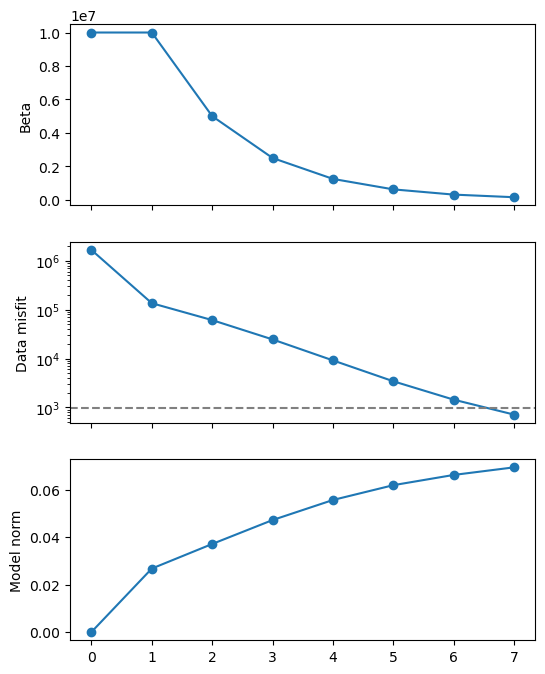

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(log.index, log.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(log.index, log.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

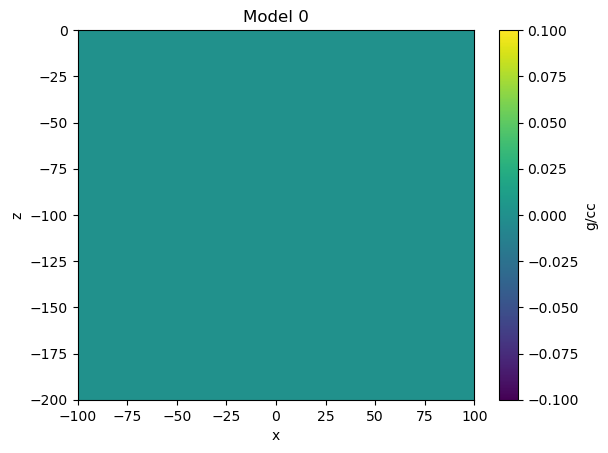

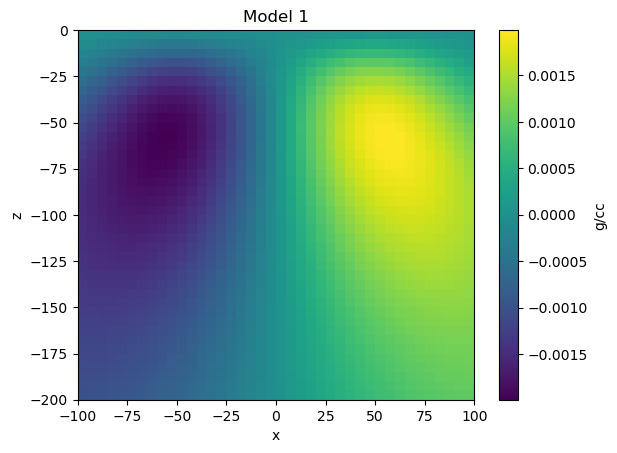

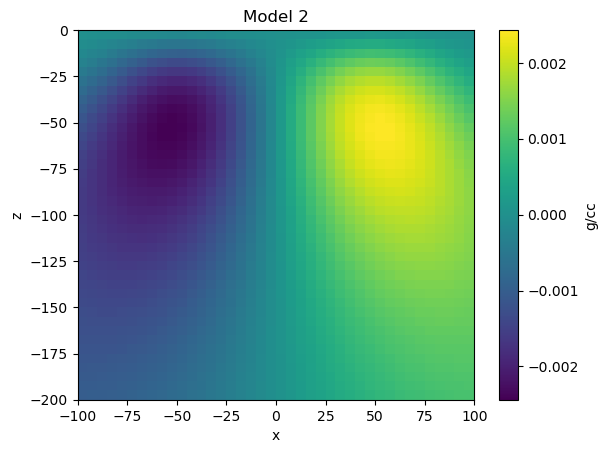

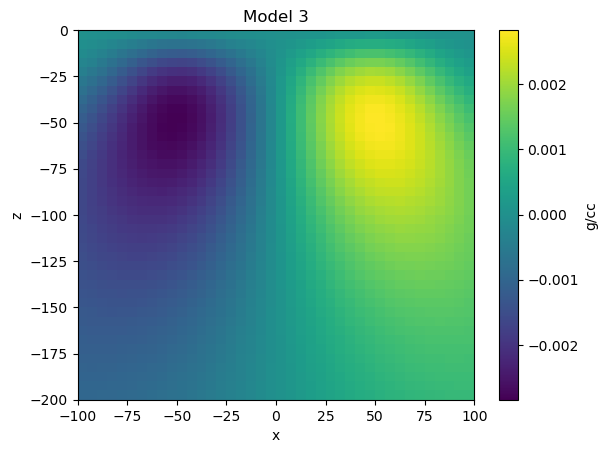

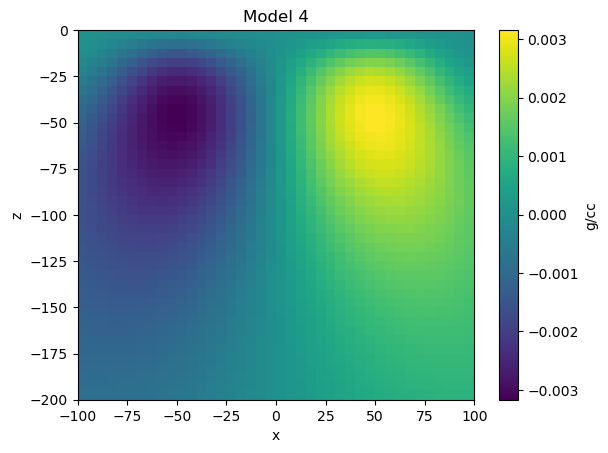

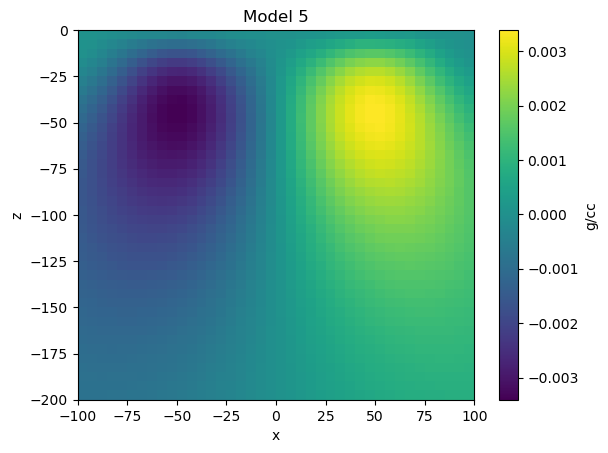

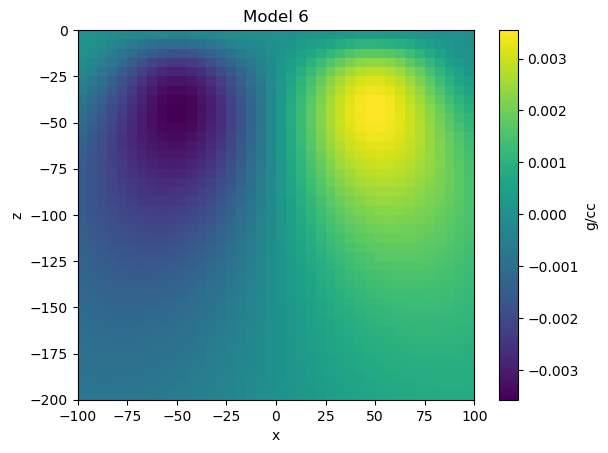

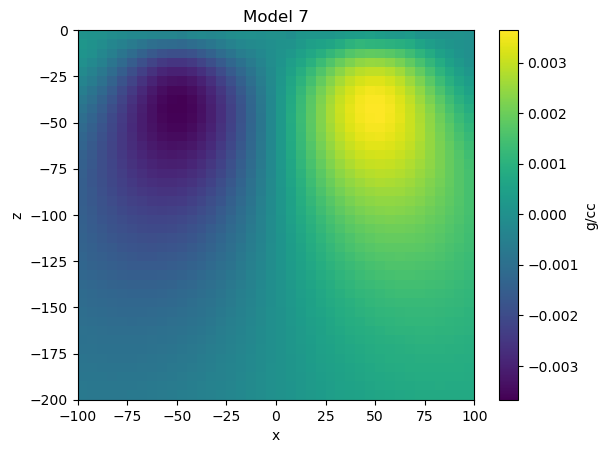

In [32]:
for i, model in enumerate(inversion.models):
    (tmp,) = mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.colorbar(tmp, label="g/cc")
    plt.title(f"Model {i}")
    plt.show()

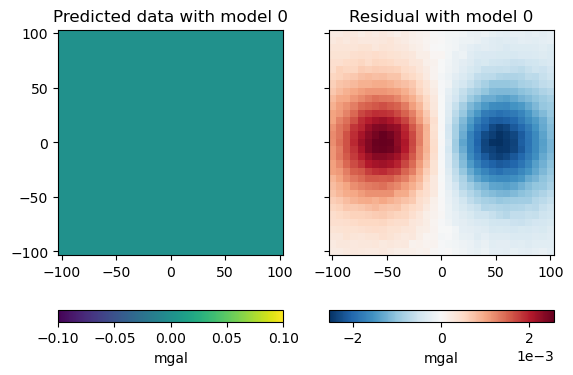

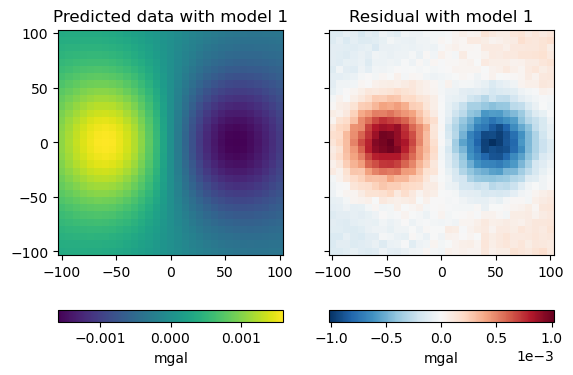

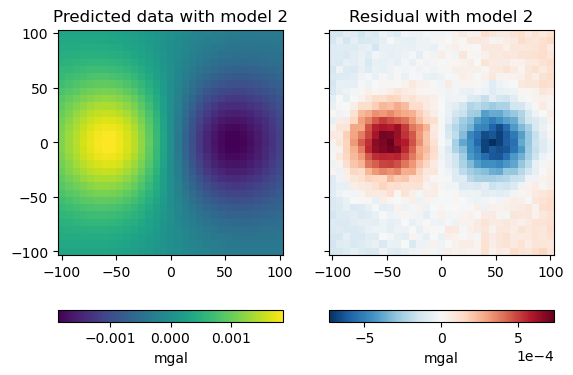

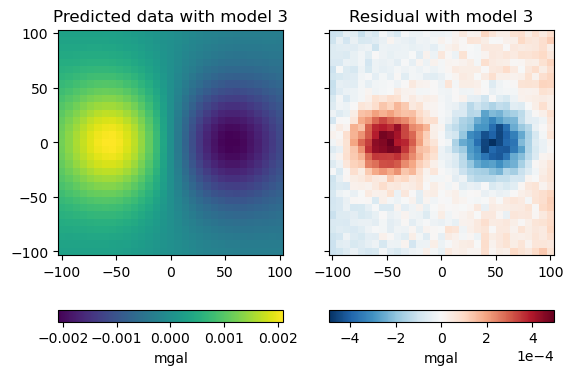

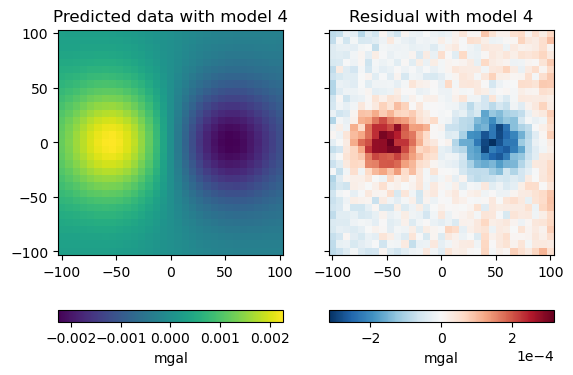

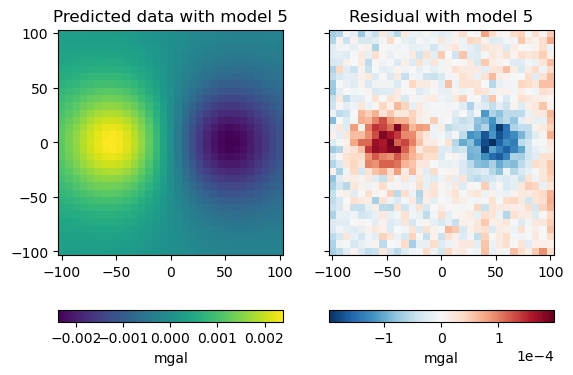

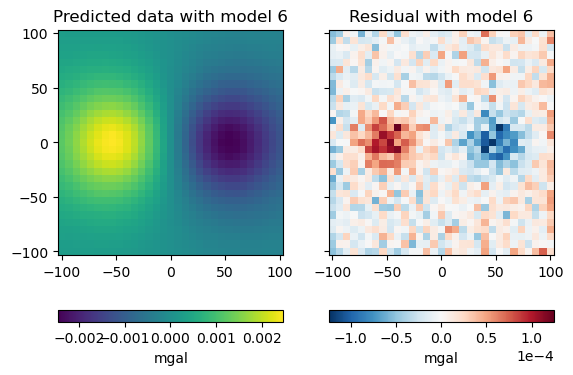

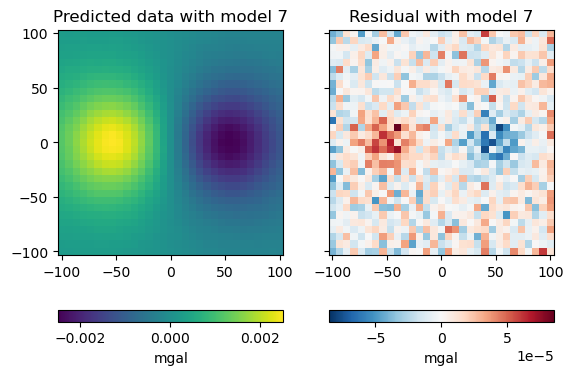

In [33]:
for i, model in enumerate(inversion.models):
    dpred = simulation(model).reshape(coordinates[0].shape)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
    tmp = axes[0].pcolormesh(*coordinates[:2], dpred)
    axes[0].set_title(f"Predicted data with model {i}")
    plt.colorbar(tmp, ax=axes[0], orientation="horizontal", label="mgal")

    residual = gz - dpred
    maxabs = vd.maxabs(residual)
    tmp = axes[1].pcolormesh(
        *coordinates[:2], residual, vmin=-maxabs, vmax=maxabs, cmap="RdBu_r"
    )
    axes[1].set_title(f"Residual with model {i}")
    cbar = plt.colorbar(tmp, ax=axes[1], orientation="horizontal", label="mgal")
    cbar.formatter.set_powerlimits((0, 0))

    for ax in axes:
        ax.set_aspect("equal")
    plt.show()